***
    
Demo EvoJAX for PINN (Physics-Informed Neural Network)
    
***

    Version: 2023-03-16
    
    Author : Nicholas Sung Wei Yong, Wong Jian Cheng, Ooi Chin Chun, Abhishek Gupta

    Contain:
    
    1. PINN for solving Non-linear Burgers equation 
    
    2. Optimize PINN using xNES + NAG solver in the JAX framework
<!--        -  as described in Nicholas Sung Wei Yong, Jian Cheng Wong, Pao-Hsiung Chiu, Abhishek Gupta, Chinchun Ooi, Yew-Soon Ong
       "Neuroevolution Surpasses Stochastic Gradient Descent for Physics-Informed Neural Networks" arXiv preprint arXiv:2212.07624 (2022). -->

# Demo

In [1]:
# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# import library
import numpy as np
import time

# import problem
from nonlinear import get_fitness, policy # Number of parameters: 260

xNES +NAG Solver

In [2]:
from jax import random, numpy as jnp
from jax.scipy.linalg import expm
from jax import jit, vmap
seed = 1
def xNES_NAG(f, x0, bs=20, lr=1e-3, sigma=1, maxtime=60, momentum_coeff=0.9, verbose=False):
    
    """ [xNES_NAG]
    Implemented baseline algo.: Exponential NES (xNES) as described in Glasmachers, Schaul, Sun, Wierstra and Schmidhuber (GECCO'10).
    Maximizes a function f. Returns (best solution found, corresponding fitness, etc.).
    
    Added Nesterov Accelerated Gradient (NAG) 
    """
    # Initialize random generator (+ seed)
    
    key, rng = random.split(random.PRNGKey(seed))
    
    # target search
    center = x0.copy()
    dim = len(x0)
    I = jnp.eye(dim)
    A = I * sigma
    momentum = jnp.zeros(dim)
    bestFitness = -jnp.inf    
    learningRate = lr     # a same learning rate apply to all updates (including mixture model coef.)
    batchSize = bs    
    bestFound = None
    bestFitness = -jnp.inf
    
    loss_ls = []
    t_training_ls = []
    
    @jit
    def project_sample(center, A, momentum, rng):
        center_proj = center + momentum_coeff * momentum
        # produce and evaluate samples
        key, rng = random.split(rng) # update random generator
        samples = random.normal(key, [batchSize, dim])
        samples_o = jnp.dot(samples, A) + center_proj
        return (samples, samples_o, rng)

    @jit
    def computeUtilities(fitnesses):
        l = jnp.argsort(fitnesses)
        ranks = jnp.argsort(l)
        L = fitnesses.size
        # smooth reshaping
        utilities = jnp.array([jnp.maximum(0., x) for x in jnp.log(L / 2. + 1.0) - jnp.log(L - jnp.array(ranks))])
        utilities /= sum(utilities)       # make the utilities sum to 1
        utilities -= 1. / L  # baseline
        return utilities

    @jit
    def update_parameters(center, A, momentum, utilities, samples):    
        # NAG parameter updates
        update_center = jnp.dot(A, jnp.dot(utilities, samples)) + momentum_coeff * momentum
        momentum = update_center
        # update center and variances
        center += update_center   
        covGradient = sum([u * (jnp.outer(s, s) - I) for (s, u) in zip(samples, utilities)])
        A = jnp.dot(A, expm(0.5 * learningRate * covGradient))
        return (center, A, momentum)
  
    
    # loop
    numEvals = 0
    t_training = 0
    while t_training <= maxtime:
        start = time.time()
        # do partial update (project into new center) & produce samples
        samples, samples_o, rng = project_sample(center, A, momentum, rng)        
        # evaluate sample fitness
        fitnesses = f(samples_o)
        # return best fitness and solution
        if max(fitnesses) > bestFitness:
            _bestFitness = jnp.argmax(fitnesses)
            bestFitness, bestFound = fitnesses[_bestFitness], samples_o[_bestFitness]
        # update no. evaluations 
        numEvals += batchSize
        # print progress
        if verbose:
            print ("Step %5d | lr %.1e | numEvals %7d  : %.3e   [Best: %.5e]" %(numEvals/batchSize, lr, numEvals,
                                                                                max(fitnesses), bestFitness))        
        
        # fitness shaping
        utilities = computeUtilities(fitnesses)
        # parameter updates
        center, A, momentum = update_parameters(center, A, momentum, utilities, samples)
        end = time.time()
        t_training += (end-start)
        
        t_training_ls.append(t_training)
        loss_ls.append(bestFitness)
        
    print("...\nRunning time: %d secs!" %(t_training))
    print("\nNo of iterations: %d iterations!" %(numEvals/batchSize))
    return bestFound, bestFitness, numEvals, t_training_ls, loss_ls


Training

In [3]:
# optimize PINN (no source -> xNES)
w0 = jnp.zeros(policy.num_params)
op_weight, op_fitness, evals, t_training_ls, loss_ls = xNES_NAG(get_fitness, w0, bs=50, lr=0.001, sigma=0.001, momentum_coeff=0.99, verbose=True)

Step     1 | lr 1.0e-03 | numEvals      50  : -1.554e-01   [Best: -1.55447e-01]
Step     2 | lr 1.0e-03 | numEvals     100  : -1.554e-01   [Best: -1.55446e-01]
Step     3 | lr 1.0e-03 | numEvals     150  : -1.554e-01   [Best: -1.55440e-01]
Step     4 | lr 1.0e-03 | numEvals     200  : -1.554e-01   [Best: -1.55432e-01]
Step     5 | lr 1.0e-03 | numEvals     250  : -1.554e-01   [Best: -1.55411e-01]
Step     6 | lr 1.0e-03 | numEvals     300  : -1.554e-01   [Best: -1.55366e-01]
Step     7 | lr 1.0e-03 | numEvals     350  : -1.553e-01   [Best: -1.55292e-01]
Step     8 | lr 1.0e-03 | numEvals     400  : -1.552e-01   [Best: -1.55189e-01]
Step     9 | lr 1.0e-03 | numEvals     450  : -1.550e-01   [Best: -1.55026e-01]
Step    10 | lr 1.0e-03 | numEvals     500  : -1.548e-01   [Best: -1.54792e-01]
Step    11 | lr 1.0e-03 | numEvals     550  : -1.545e-01   [Best: -1.54495e-01]
Step    12 | lr 1.0e-03 | numEvals     600  : -1.541e-01   [Best: -1.54103e-01]
Step    13 | lr 1.0e-03 | numEvals     6

Step   117 | lr 1.0e-03 | numEvals    5850  : -1.105e-01   [Best: -1.07121e-01]
Step   118 | lr 1.0e-03 | numEvals    5900  : -1.092e-01   [Best: -1.07121e-01]
Step   119 | lr 1.0e-03 | numEvals    5950  : -1.081e-01   [Best: -1.07121e-01]
Step   120 | lr 1.0e-03 | numEvals    6000  : -1.074e-01   [Best: -1.07121e-01]
Step   121 | lr 1.0e-03 | numEvals    6050  : -1.072e-01   [Best: -1.07121e-01]
Step   122 | lr 1.0e-03 | numEvals    6100  : -1.074e-01   [Best: -1.07121e-01]
Step   123 | lr 1.0e-03 | numEvals    6150  : -1.080e-01   [Best: -1.07121e-01]
Step   124 | lr 1.0e-03 | numEvals    6200  : -1.088e-01   [Best: -1.07121e-01]
Step   125 | lr 1.0e-03 | numEvals    6250  : -1.100e-01   [Best: -1.07121e-01]
Step   126 | lr 1.0e-03 | numEvals    6300  : -1.111e-01   [Best: -1.07121e-01]
Step   127 | lr 1.0e-03 | numEvals    6350  : -1.124e-01   [Best: -1.07121e-01]
Step   128 | lr 1.0e-03 | numEvals    6400  : -1.138e-01   [Best: -1.07121e-01]
Step   129 | lr 1.0e-03 | numEvals    64

Step   228 | lr 1.0e-03 | numEvals   11400  : -1.037e-01   [Best: -1.03739e-01]
Step   229 | lr 1.0e-03 | numEvals   11450  : -1.034e-01   [Best: -1.03391e-01]
Step   230 | lr 1.0e-03 | numEvals   11500  : -1.030e-01   [Best: -1.03042e-01]
Step   231 | lr 1.0e-03 | numEvals   11550  : -1.027e-01   [Best: -1.02695e-01]
Step   232 | lr 1.0e-03 | numEvals   11600  : -1.023e-01   [Best: -1.02274e-01]
Step   233 | lr 1.0e-03 | numEvals   11650  : -1.018e-01   [Best: -1.01827e-01]
Step   234 | lr 1.0e-03 | numEvals   11700  : -1.013e-01   [Best: -1.01326e-01]
Step   235 | lr 1.0e-03 | numEvals   11750  : -1.008e-01   [Best: -1.00767e-01]
Step   236 | lr 1.0e-03 | numEvals   11800  : -1.002e-01   [Best: -1.00157e-01]
Step   237 | lr 1.0e-03 | numEvals   11850  : -9.949e-02   [Best: -9.94856e-02]
Step   238 | lr 1.0e-03 | numEvals   11900  : -9.875e-02   [Best: -9.87521e-02]
Step   239 | lr 1.0e-03 | numEvals   11950  : -9.800e-02   [Best: -9.79997e-02]
Step   240 | lr 1.0e-03 | numEvals   120

Step   339 | lr 1.0e-03 | numEvals   16950  : -3.663e-02   [Best: -3.66310e-02]
Step   340 | lr 1.0e-03 | numEvals   17000  : -3.489e-02   [Best: -3.48860e-02]
Step   341 | lr 1.0e-03 | numEvals   17050  : -3.317e-02   [Best: -3.31650e-02]
Step   342 | lr 1.0e-03 | numEvals   17100  : -3.143e-02   [Best: -3.14285e-02]
Step   343 | lr 1.0e-03 | numEvals   17150  : -2.979e-02   [Best: -2.97936e-02]
Step   344 | lr 1.0e-03 | numEvals   17200  : -2.819e-02   [Best: -2.81877e-02]
Step   345 | lr 1.0e-03 | numEvals   17250  : -2.694e-02   [Best: -2.69409e-02]
Step   346 | lr 1.0e-03 | numEvals   17300  : -2.573e-02   [Best: -2.57327e-02]
Step   347 | lr 1.0e-03 | numEvals   17350  : -2.473e-02   [Best: -2.47265e-02]
Step   348 | lr 1.0e-03 | numEvals   17400  : -2.393e-02   [Best: -2.39285e-02]
Step   349 | lr 1.0e-03 | numEvals   17450  : -2.339e-02   [Best: -2.33937e-02]
Step   350 | lr 1.0e-03 | numEvals   17500  : -2.300e-02   [Best: -2.30010e-02]
Step   351 | lr 1.0e-03 | numEvals   175

Step   450 | lr 1.0e-03 | numEvals   22500  : -9.827e-03   [Best: -9.82664e-03]
Step   451 | lr 1.0e-03 | numEvals   22550  : -9.765e-03   [Best: -9.76455e-03]
Step   452 | lr 1.0e-03 | numEvals   22600  : -9.709e-03   [Best: -9.70912e-03]
Step   453 | lr 1.0e-03 | numEvals   22650  : -9.646e-03   [Best: -9.64568e-03]
Step   454 | lr 1.0e-03 | numEvals   22700  : -9.587e-03   [Best: -9.58747e-03]
Step   455 | lr 1.0e-03 | numEvals   22750  : -9.527e-03   [Best: -9.52698e-03]
Step   456 | lr 1.0e-03 | numEvals   22800  : -9.497e-03   [Best: -9.49718e-03]
Step   457 | lr 1.0e-03 | numEvals   22850  : -9.457e-03   [Best: -9.45662e-03]
Step   458 | lr 1.0e-03 | numEvals   22900  : -9.427e-03   [Best: -9.42747e-03]
Step   459 | lr 1.0e-03 | numEvals   22950  : -9.383e-03   [Best: -9.38282e-03]
Step   460 | lr 1.0e-03 | numEvals   23000  : -9.346e-03   [Best: -9.34591e-03]
Step   461 | lr 1.0e-03 | numEvals   23050  : -9.312e-03   [Best: -9.31181e-03]
Step   462 | lr 1.0e-03 | numEvals   231

Step   556 | lr 1.0e-03 | numEvals   27800  : -7.408e-03   [Best: -7.40778e-03]
Step   557 | lr 1.0e-03 | numEvals   27850  : -7.401e-03   [Best: -7.40139e-03]
Step   558 | lr 1.0e-03 | numEvals   27900  : -7.393e-03   [Best: -7.39338e-03]
Step   559 | lr 1.0e-03 | numEvals   27950  : -7.385e-03   [Best: -7.38529e-03]
Step   560 | lr 1.0e-03 | numEvals   28000  : -7.380e-03   [Best: -7.37952e-03]
Step   561 | lr 1.0e-03 | numEvals   28050  : -7.369e-03   [Best: -7.36925e-03]
Step   562 | lr 1.0e-03 | numEvals   28100  : -7.355e-03   [Best: -7.35534e-03]
Step   563 | lr 1.0e-03 | numEvals   28150  : -7.353e-03   [Best: -7.35318e-03]
Step   564 | lr 1.0e-03 | numEvals   28200  : -7.345e-03   [Best: -7.34485e-03]
Step   565 | lr 1.0e-03 | numEvals   28250  : -7.335e-03   [Best: -7.33529e-03]
Step   566 | lr 1.0e-03 | numEvals   28300  : -7.327e-03   [Best: -7.32705e-03]
Step   567 | lr 1.0e-03 | numEvals   28350  : -7.316e-03   [Best: -7.31638e-03]
Step   568 | lr 1.0e-03 | numEvals   284

Step   674 | lr 1.0e-03 | numEvals   33700  : -6.231e-03   [Best: -6.23126e-03]
Step   675 | lr 1.0e-03 | numEvals   33750  : -6.237e-03   [Best: -6.23126e-03]
Step   676 | lr 1.0e-03 | numEvals   33800  : -6.229e-03   [Best: -6.22887e-03]
Step   677 | lr 1.0e-03 | numEvals   33850  : -6.231e-03   [Best: -6.22887e-03]
Step   678 | lr 1.0e-03 | numEvals   33900  : -6.235e-03   [Best: -6.22887e-03]
Step   679 | lr 1.0e-03 | numEvals   33950  : -6.232e-03   [Best: -6.22887e-03]
Step   680 | lr 1.0e-03 | numEvals   34000  : -6.239e-03   [Best: -6.22887e-03]
Step   681 | lr 1.0e-03 | numEvals   34050  : -6.235e-03   [Best: -6.22887e-03]
Step   682 | lr 1.0e-03 | numEvals   34100  : -6.230e-03   [Best: -6.22887e-03]
Step   683 | lr 1.0e-03 | numEvals   34150  : -6.228e-03   [Best: -6.22836e-03]
Step   684 | lr 1.0e-03 | numEvals   34200  : -6.225e-03   [Best: -6.22528e-03]
Step   685 | lr 1.0e-03 | numEvals   34250  : -6.227e-03   [Best: -6.22528e-03]
Step   686 | lr 1.0e-03 | numEvals   343

Step   783 | lr 1.0e-03 | numEvals   39150  : -5.877e-03   [Best: -5.87733e-03]
Step   784 | lr 1.0e-03 | numEvals   39200  : -5.876e-03   [Best: -5.87624e-03]
Step   785 | lr 1.0e-03 | numEvals   39250  : -5.873e-03   [Best: -5.87304e-03]
Step   786 | lr 1.0e-03 | numEvals   39300  : -5.869e-03   [Best: -5.86938e-03]
Step   787 | lr 1.0e-03 | numEvals   39350  : -5.867e-03   [Best: -5.86743e-03]
Step   788 | lr 1.0e-03 | numEvals   39400  : -5.866e-03   [Best: -5.86584e-03]
Step   789 | lr 1.0e-03 | numEvals   39450  : -5.867e-03   [Best: -5.86584e-03]
Step   790 | lr 1.0e-03 | numEvals   39500  : -5.865e-03   [Best: -5.86503e-03]
Step   791 | lr 1.0e-03 | numEvals   39550  : -5.862e-03   [Best: -5.86161e-03]
Step   792 | lr 1.0e-03 | numEvals   39600  : -5.861e-03   [Best: -5.86055e-03]
Step   793 | lr 1.0e-03 | numEvals   39650  : -5.861e-03   [Best: -5.86055e-03]
Step   794 | lr 1.0e-03 | numEvals   39700  : -5.860e-03   [Best: -5.86010e-03]
Step   795 | lr 1.0e-03 | numEvals   397

Step   898 | lr 1.0e-03 | numEvals   44900  : -5.774e-03   [Best: -5.75474e-03]
Step   899 | lr 1.0e-03 | numEvals   44950  : -5.767e-03   [Best: -5.75474e-03]
Step   900 | lr 1.0e-03 | numEvals   45000  : -5.762e-03   [Best: -5.75474e-03]
Step   901 | lr 1.0e-03 | numEvals   45050  : -5.759e-03   [Best: -5.75474e-03]
Step   902 | lr 1.0e-03 | numEvals   45100  : -5.759e-03   [Best: -5.75474e-03]
Step   903 | lr 1.0e-03 | numEvals   45150  : -5.756e-03   [Best: -5.75474e-03]
Step   904 | lr 1.0e-03 | numEvals   45200  : -5.754e-03   [Best: -5.75371e-03]
Step   905 | lr 1.0e-03 | numEvals   45250  : -5.760e-03   [Best: -5.75371e-03]
Step   906 | lr 1.0e-03 | numEvals   45300  : -5.766e-03   [Best: -5.75371e-03]
Step   907 | lr 1.0e-03 | numEvals   45350  : -5.762e-03   [Best: -5.75371e-03]
Step   908 | lr 1.0e-03 | numEvals   45400  : -5.767e-03   [Best: -5.75371e-03]
Step   909 | lr 1.0e-03 | numEvals   45450  : -5.765e-03   [Best: -5.75371e-03]
Step   910 | lr 1.0e-03 | numEvals   455

Step  1008 | lr 1.0e-03 | numEvals   50400  : -5.547e-03   [Best: -5.54725e-03]
Step  1009 | lr 1.0e-03 | numEvals   50450  : -5.539e-03   [Best: -5.53901e-03]
Step  1010 | lr 1.0e-03 | numEvals   50500  : -5.543e-03   [Best: -5.53901e-03]
Step  1011 | lr 1.0e-03 | numEvals   50550  : -5.539e-03   [Best: -5.53901e-03]
Step  1012 | lr 1.0e-03 | numEvals   50600  : -5.545e-03   [Best: -5.53901e-03]
Step  1013 | lr 1.0e-03 | numEvals   50650  : -5.540e-03   [Best: -5.53901e-03]
Step  1014 | lr 1.0e-03 | numEvals   50700  : -5.536e-03   [Best: -5.53640e-03]
Step  1015 | lr 1.0e-03 | numEvals   50750  : -5.542e-03   [Best: -5.53640e-03]
Step  1016 | lr 1.0e-03 | numEvals   50800  : -5.539e-03   [Best: -5.53640e-03]
Step  1017 | lr 1.0e-03 | numEvals   50850  : -5.536e-03   [Best: -5.53637e-03]
Step  1018 | lr 1.0e-03 | numEvals   50900  : -5.531e-03   [Best: -5.53134e-03]
Step  1019 | lr 1.0e-03 | numEvals   50950  : -5.523e-03   [Best: -5.52289e-03]
Step  1020 | lr 1.0e-03 | numEvals   510

Step  1120 | lr 1.0e-03 | numEvals   56000  : -5.384e-03   [Best: -5.38219e-03]
Step  1121 | lr 1.0e-03 | numEvals   56050  : -5.377e-03   [Best: -5.37747e-03]
Step  1122 | lr 1.0e-03 | numEvals   56100  : -5.372e-03   [Best: -5.37186e-03]
Step  1123 | lr 1.0e-03 | numEvals   56150  : -5.371e-03   [Best: -5.37144e-03]
Step  1124 | lr 1.0e-03 | numEvals   56200  : -5.370e-03   [Best: -5.36994e-03]
Step  1125 | lr 1.0e-03 | numEvals   56250  : -5.364e-03   [Best: -5.36404e-03]
Step  1126 | lr 1.0e-03 | numEvals   56300  : -5.366e-03   [Best: -5.36404e-03]
Step  1127 | lr 1.0e-03 | numEvals   56350  : -5.363e-03   [Best: -5.36261e-03]
Step  1128 | lr 1.0e-03 | numEvals   56400  : -5.355e-03   [Best: -5.35521e-03]
Step  1129 | lr 1.0e-03 | numEvals   56450  : -5.354e-03   [Best: -5.35366e-03]
Step  1130 | lr 1.0e-03 | numEvals   56500  : -5.349e-03   [Best: -5.34945e-03]
Step  1131 | lr 1.0e-03 | numEvals   56550  : -5.349e-03   [Best: -5.34901e-03]
Step  1132 | lr 1.0e-03 | numEvals   566

Step  1236 | lr 1.0e-03 | numEvals   61800  : -5.300e-03   [Best: -5.26790e-03]
Step  1237 | lr 1.0e-03 | numEvals   61850  : -5.309e-03   [Best: -5.26790e-03]
Step  1238 | lr 1.0e-03 | numEvals   61900  : -5.302e-03   [Best: -5.26790e-03]
Step  1239 | lr 1.0e-03 | numEvals   61950  : -5.307e-03   [Best: -5.26790e-03]
Step  1240 | lr 1.0e-03 | numEvals   62000  : -5.309e-03   [Best: -5.26790e-03]
Step  1241 | lr 1.0e-03 | numEvals   62050  : -5.302e-03   [Best: -5.26790e-03]
Step  1242 | lr 1.0e-03 | numEvals   62100  : -5.302e-03   [Best: -5.26790e-03]
Step  1243 | lr 1.0e-03 | numEvals   62150  : -5.297e-03   [Best: -5.26790e-03]
Step  1244 | lr 1.0e-03 | numEvals   62200  : -5.297e-03   [Best: -5.26790e-03]
Step  1245 | lr 1.0e-03 | numEvals   62250  : -5.292e-03   [Best: -5.26790e-03]
Step  1246 | lr 1.0e-03 | numEvals   62300  : -5.296e-03   [Best: -5.26790e-03]
Step  1247 | lr 1.0e-03 | numEvals   62350  : -5.293e-03   [Best: -5.26790e-03]
Step  1248 | lr 1.0e-03 | numEvals   624

Step  1356 | lr 1.0e-03 | numEvals   67800  : -5.295e-03   [Best: -5.25861e-03]
Step  1357 | lr 1.0e-03 | numEvals   67850  : -5.287e-03   [Best: -5.25861e-03]
Step  1358 | lr 1.0e-03 | numEvals   67900  : -5.295e-03   [Best: -5.25861e-03]
Step  1359 | lr 1.0e-03 | numEvals   67950  : -5.293e-03   [Best: -5.25861e-03]
Step  1360 | lr 1.0e-03 | numEvals   68000  : -5.299e-03   [Best: -5.25861e-03]
Step  1361 | lr 1.0e-03 | numEvals   68050  : -5.298e-03   [Best: -5.25861e-03]
Step  1362 | lr 1.0e-03 | numEvals   68100  : -5.289e-03   [Best: -5.25861e-03]
Step  1363 | lr 1.0e-03 | numEvals   68150  : -5.295e-03   [Best: -5.25861e-03]
Step  1364 | lr 1.0e-03 | numEvals   68200  : -5.301e-03   [Best: -5.25861e-03]
Step  1365 | lr 1.0e-03 | numEvals   68250  : -5.302e-03   [Best: -5.25861e-03]
Step  1366 | lr 1.0e-03 | numEvals   68300  : -5.300e-03   [Best: -5.25861e-03]
Step  1367 | lr 1.0e-03 | numEvals   68350  : -5.300e-03   [Best: -5.25861e-03]
Step  1368 | lr 1.0e-03 | numEvals   684

Step  1459 | lr 1.0e-03 | numEvals   72950  : -5.272e-03   [Best: -5.22770e-03]
Step  1460 | lr 1.0e-03 | numEvals   73000  : -5.269e-03   [Best: -5.22770e-03]
Step  1461 | lr 1.0e-03 | numEvals   73050  : -5.278e-03   [Best: -5.22770e-03]
Step  1462 | lr 1.0e-03 | numEvals   73100  : -5.266e-03   [Best: -5.22770e-03]
Step  1463 | lr 1.0e-03 | numEvals   73150  : -5.277e-03   [Best: -5.22770e-03]
Step  1464 | lr 1.0e-03 | numEvals   73200  : -5.269e-03   [Best: -5.22770e-03]
Step  1465 | lr 1.0e-03 | numEvals   73250  : -5.281e-03   [Best: -5.22770e-03]
Step  1466 | lr 1.0e-03 | numEvals   73300  : -5.292e-03   [Best: -5.22770e-03]
Step  1467 | lr 1.0e-03 | numEvals   73350  : -5.302e-03   [Best: -5.22770e-03]
Step  1468 | lr 1.0e-03 | numEvals   73400  : -5.306e-03   [Best: -5.22770e-03]
Step  1469 | lr 1.0e-03 | numEvals   73450  : -5.307e-03   [Best: -5.22770e-03]
Step  1470 | lr 1.0e-03 | numEvals   73500  : -5.312e-03   [Best: -5.22770e-03]
Step  1471 | lr 1.0e-03 | numEvals   735

Step  1578 | lr 1.0e-03 | numEvals   78900  : -5.391e-03   [Best: -5.22770e-03]
Step  1579 | lr 1.0e-03 | numEvals   78950  : -5.395e-03   [Best: -5.22770e-03]
Step  1580 | lr 1.0e-03 | numEvals   79000  : -5.398e-03   [Best: -5.22770e-03]
Step  1581 | lr 1.0e-03 | numEvals   79050  : -5.404e-03   [Best: -5.22770e-03]
Step  1582 | lr 1.0e-03 | numEvals   79100  : -5.420e-03   [Best: -5.22770e-03]
Step  1583 | lr 1.0e-03 | numEvals   79150  : -5.424e-03   [Best: -5.22770e-03]
Step  1584 | lr 1.0e-03 | numEvals   79200  : -5.418e-03   [Best: -5.22770e-03]
Step  1585 | lr 1.0e-03 | numEvals   79250  : -5.414e-03   [Best: -5.22770e-03]
Step  1586 | lr 1.0e-03 | numEvals   79300  : -5.415e-03   [Best: -5.22770e-03]
Step  1587 | lr 1.0e-03 | numEvals   79350  : -5.415e-03   [Best: -5.22770e-03]
Step  1588 | lr 1.0e-03 | numEvals   79400  : -5.407e-03   [Best: -5.22770e-03]
Step  1589 | lr 1.0e-03 | numEvals   79450  : -5.421e-03   [Best: -5.22770e-03]
Step  1590 | lr 1.0e-03 | numEvals   795

Step  1697 | lr 1.0e-03 | numEvals   84850  : -5.382e-03   [Best: -5.22770e-03]
Step  1698 | lr 1.0e-03 | numEvals   84900  : -5.378e-03   [Best: -5.22770e-03]
Step  1699 | lr 1.0e-03 | numEvals   84950  : -5.397e-03   [Best: -5.22770e-03]
Step  1700 | lr 1.0e-03 | numEvals   85000  : -5.369e-03   [Best: -5.22770e-03]
Step  1701 | lr 1.0e-03 | numEvals   85050  : -5.387e-03   [Best: -5.22770e-03]
Step  1702 | lr 1.0e-03 | numEvals   85100  : -5.382e-03   [Best: -5.22770e-03]
Step  1703 | lr 1.0e-03 | numEvals   85150  : -5.384e-03   [Best: -5.22770e-03]
Step  1704 | lr 1.0e-03 | numEvals   85200  : -5.391e-03   [Best: -5.22770e-03]
Step  1705 | lr 1.0e-03 | numEvals   85250  : -5.376e-03   [Best: -5.22770e-03]
Step  1706 | lr 1.0e-03 | numEvals   85300  : -5.377e-03   [Best: -5.22770e-03]
Step  1707 | lr 1.0e-03 | numEvals   85350  : -5.380e-03   [Best: -5.22770e-03]
Step  1708 | lr 1.0e-03 | numEvals   85400  : -5.381e-03   [Best: -5.22770e-03]
Step  1709 | lr 1.0e-03 | numEvals   854

Step  1816 | lr 1.0e-03 | numEvals   90800  : -5.401e-03   [Best: -5.22770e-03]
Step  1817 | lr 1.0e-03 | numEvals   90850  : -5.398e-03   [Best: -5.22770e-03]
Step  1818 | lr 1.0e-03 | numEvals   90900  : -5.397e-03   [Best: -5.22770e-03]
Step  1819 | lr 1.0e-03 | numEvals   90950  : -5.391e-03   [Best: -5.22770e-03]
Step  1820 | lr 1.0e-03 | numEvals   91000  : -5.393e-03   [Best: -5.22770e-03]
Step  1821 | lr 1.0e-03 | numEvals   91050  : -5.399e-03   [Best: -5.22770e-03]
Step  1822 | lr 1.0e-03 | numEvals   91100  : -5.404e-03   [Best: -5.22770e-03]
Step  1823 | lr 1.0e-03 | numEvals   91150  : -5.415e-03   [Best: -5.22770e-03]
Step  1824 | lr 1.0e-03 | numEvals   91200  : -5.408e-03   [Best: -5.22770e-03]
Step  1825 | lr 1.0e-03 | numEvals   91250  : -5.412e-03   [Best: -5.22770e-03]
Step  1826 | lr 1.0e-03 | numEvals   91300  : -5.420e-03   [Best: -5.22770e-03]
Step  1827 | lr 1.0e-03 | numEvals   91350  : -5.442e-03   [Best: -5.22770e-03]
Step  1828 | lr 1.0e-03 | numEvals   914

Step  1935 | lr 1.0e-03 | numEvals   96750  : -5.280e-03   [Best: -5.22770e-03]
Step  1936 | lr 1.0e-03 | numEvals   96800  : -5.284e-03   [Best: -5.22770e-03]
Step  1937 | lr 1.0e-03 | numEvals   96850  : -5.309e-03   [Best: -5.22770e-03]
Step  1938 | lr 1.0e-03 | numEvals   96900  : -5.291e-03   [Best: -5.22770e-03]
Step  1939 | lr 1.0e-03 | numEvals   96950  : -5.314e-03   [Best: -5.22770e-03]
Step  1940 | lr 1.0e-03 | numEvals   97000  : -5.306e-03   [Best: -5.22770e-03]
Step  1941 | lr 1.0e-03 | numEvals   97050  : -5.320e-03   [Best: -5.22770e-03]
Step  1942 | lr 1.0e-03 | numEvals   97100  : -5.328e-03   [Best: -5.22770e-03]
Step  1943 | lr 1.0e-03 | numEvals   97150  : -5.317e-03   [Best: -5.22770e-03]
Step  1944 | lr 1.0e-03 | numEvals   97200  : -5.331e-03   [Best: -5.22770e-03]
Step  1945 | lr 1.0e-03 | numEvals   97250  : -5.348e-03   [Best: -5.22770e-03]
Step  1946 | lr 1.0e-03 | numEvals   97300  : -5.343e-03   [Best: -5.22770e-03]
Step  1947 | lr 1.0e-03 | numEvals   973

Step  2054 | lr 1.0e-03 | numEvals  102700  : -5.397e-03   [Best: -5.22770e-03]
Step  2055 | lr 1.0e-03 | numEvals  102750  : -5.390e-03   [Best: -5.22770e-03]
Step  2056 | lr 1.0e-03 | numEvals  102800  : -5.398e-03   [Best: -5.22770e-03]
Step  2057 | lr 1.0e-03 | numEvals  102850  : -5.372e-03   [Best: -5.22770e-03]
Step  2058 | lr 1.0e-03 | numEvals  102900  : -5.382e-03   [Best: -5.22770e-03]
Step  2059 | lr 1.0e-03 | numEvals  102950  : -5.388e-03   [Best: -5.22770e-03]
Step  2060 | lr 1.0e-03 | numEvals  103000  : -5.363e-03   [Best: -5.22770e-03]
Step  2061 | lr 1.0e-03 | numEvals  103050  : -5.383e-03   [Best: -5.22770e-03]
Step  2062 | lr 1.0e-03 | numEvals  103100  : -5.382e-03   [Best: -5.22770e-03]
Step  2063 | lr 1.0e-03 | numEvals  103150  : -5.377e-03   [Best: -5.22770e-03]
Step  2064 | lr 1.0e-03 | numEvals  103200  : -5.377e-03   [Best: -5.22770e-03]
Step  2065 | lr 1.0e-03 | numEvals  103250  : -5.392e-03   [Best: -5.22770e-03]
Step  2066 | lr 1.0e-03 | numEvals  1033

Step  2172 | lr 1.0e-03 | numEvals  108600  : -5.582e-03   [Best: -5.22770e-03]
Step  2173 | lr 1.0e-03 | numEvals  108650  : -5.568e-03   [Best: -5.22770e-03]
Step  2174 | lr 1.0e-03 | numEvals  108700  : -5.537e-03   [Best: -5.22770e-03]
Step  2175 | lr 1.0e-03 | numEvals  108750  : -5.511e-03   [Best: -5.22770e-03]
Step  2176 | lr 1.0e-03 | numEvals  108800  : -5.498e-03   [Best: -5.22770e-03]
Step  2177 | lr 1.0e-03 | numEvals  108850  : -5.487e-03   [Best: -5.22770e-03]
Step  2178 | lr 1.0e-03 | numEvals  108900  : -5.467e-03   [Best: -5.22770e-03]
Step  2179 | lr 1.0e-03 | numEvals  108950  : -5.445e-03   [Best: -5.22770e-03]
Step  2180 | lr 1.0e-03 | numEvals  109000  : -5.427e-03   [Best: -5.22770e-03]
Step  2181 | lr 1.0e-03 | numEvals  109050  : -5.416e-03   [Best: -5.22770e-03]
Step  2182 | lr 1.0e-03 | numEvals  109100  : -5.405e-03   [Best: -5.22770e-03]
Step  2183 | lr 1.0e-03 | numEvals  109150  : -5.410e-03   [Best: -5.22770e-03]
Step  2184 | lr 1.0e-03 | numEvals  1092

Step  2291 | lr 1.0e-03 | numEvals  114550  : -5.170e-03   [Best: -5.16721e-03]
Step  2292 | lr 1.0e-03 | numEvals  114600  : -5.161e-03   [Best: -5.16103e-03]
Step  2293 | lr 1.0e-03 | numEvals  114650  : -5.165e-03   [Best: -5.16103e-03]
Step  2294 | lr 1.0e-03 | numEvals  114700  : -5.159e-03   [Best: -5.15870e-03]
Step  2295 | lr 1.0e-03 | numEvals  114750  : -5.164e-03   [Best: -5.15870e-03]
Step  2296 | lr 1.0e-03 | numEvals  114800  : -5.173e-03   [Best: -5.15870e-03]
Step  2297 | lr 1.0e-03 | numEvals  114850  : -5.173e-03   [Best: -5.15870e-03]
Step  2298 | lr 1.0e-03 | numEvals  114900  : -5.180e-03   [Best: -5.15870e-03]
Step  2299 | lr 1.0e-03 | numEvals  114950  : -5.183e-03   [Best: -5.15870e-03]
Step  2300 | lr 1.0e-03 | numEvals  115000  : -5.186e-03   [Best: -5.15870e-03]
Step  2301 | lr 1.0e-03 | numEvals  115050  : -5.192e-03   [Best: -5.15870e-03]
Step  2302 | lr 1.0e-03 | numEvals  115100  : -5.191e-03   [Best: -5.15870e-03]
Step  2303 | lr 1.0e-03 | numEvals  1151

Step  2403 | lr 1.0e-03 | numEvals  120150  : -5.128e-03   [Best: -5.12000e-03]
Step  2404 | lr 1.0e-03 | numEvals  120200  : -5.129e-03   [Best: -5.12000e-03]
Step  2405 | lr 1.0e-03 | numEvals  120250  : -5.129e-03   [Best: -5.12000e-03]
Step  2406 | lr 1.0e-03 | numEvals  120300  : -5.131e-03   [Best: -5.12000e-03]
Step  2407 | lr 1.0e-03 | numEvals  120350  : -5.131e-03   [Best: -5.12000e-03]
Step  2408 | lr 1.0e-03 | numEvals  120400  : -5.135e-03   [Best: -5.12000e-03]
Step  2409 | lr 1.0e-03 | numEvals  120450  : -5.134e-03   [Best: -5.12000e-03]
Step  2410 | lr 1.0e-03 | numEvals  120500  : -5.136e-03   [Best: -5.12000e-03]
Step  2411 | lr 1.0e-03 | numEvals  120550  : -5.136e-03   [Best: -5.12000e-03]
Step  2412 | lr 1.0e-03 | numEvals  120600  : -5.141e-03   [Best: -5.12000e-03]
Step  2413 | lr 1.0e-03 | numEvals  120650  : -5.144e-03   [Best: -5.12000e-03]
Step  2414 | lr 1.0e-03 | numEvals  120700  : -5.146e-03   [Best: -5.12000e-03]
Step  2415 | lr 1.0e-03 | numEvals  1207

Step  2521 | lr 1.0e-03 | numEvals  126050  : -5.140e-03   [Best: -5.11366e-03]
Step  2522 | lr 1.0e-03 | numEvals  126100  : -5.137e-03   [Best: -5.11366e-03]
Step  2523 | lr 1.0e-03 | numEvals  126150  : -5.136e-03   [Best: -5.11366e-03]
Step  2524 | lr 1.0e-03 | numEvals  126200  : -5.133e-03   [Best: -5.11366e-03]
Step  2525 | lr 1.0e-03 | numEvals  126250  : -5.125e-03   [Best: -5.11366e-03]
Step  2526 | lr 1.0e-03 | numEvals  126300  : -5.121e-03   [Best: -5.11366e-03]
Step  2527 | lr 1.0e-03 | numEvals  126350  : -5.117e-03   [Best: -5.11366e-03]
Step  2528 | lr 1.0e-03 | numEvals  126400  : -5.116e-03   [Best: -5.11366e-03]
Step  2529 | lr 1.0e-03 | numEvals  126450  : -5.112e-03   [Best: -5.11243e-03]
Step  2530 | lr 1.0e-03 | numEvals  126500  : -5.112e-03   [Best: -5.11158e-03]
Step  2531 | lr 1.0e-03 | numEvals  126550  : -5.109e-03   [Best: -5.10875e-03]
Step  2532 | lr 1.0e-03 | numEvals  126600  : -5.109e-03   [Best: -5.10875e-03]
Step  2533 | lr 1.0e-03 | numEvals  1266

Step  2640 | lr 1.0e-03 | numEvals  132000  : -5.139e-03   [Best: -5.10393e-03]
Step  2641 | lr 1.0e-03 | numEvals  132050  : -5.137e-03   [Best: -5.10393e-03]
Step  2642 | lr 1.0e-03 | numEvals  132100  : -5.141e-03   [Best: -5.10393e-03]
Step  2643 | lr 1.0e-03 | numEvals  132150  : -5.141e-03   [Best: -5.10393e-03]
Step  2644 | lr 1.0e-03 | numEvals  132200  : -5.141e-03   [Best: -5.10393e-03]
Step  2645 | lr 1.0e-03 | numEvals  132250  : -5.149e-03   [Best: -5.10393e-03]
Step  2646 | lr 1.0e-03 | numEvals  132300  : -5.140e-03   [Best: -5.10393e-03]
Step  2647 | lr 1.0e-03 | numEvals  132350  : -5.131e-03   [Best: -5.10393e-03]
Step  2648 | lr 1.0e-03 | numEvals  132400  : -5.131e-03   [Best: -5.10393e-03]
Step  2649 | lr 1.0e-03 | numEvals  132450  : -5.131e-03   [Best: -5.10393e-03]
Step  2650 | lr 1.0e-03 | numEvals  132500  : -5.125e-03   [Best: -5.10393e-03]
Step  2651 | lr 1.0e-03 | numEvals  132550  : -5.130e-03   [Best: -5.10393e-03]
Step  2652 | lr 1.0e-03 | numEvals  1326

Step  2756 | lr 1.0e-03 | numEvals  137800  : -5.075e-03   [Best: -5.07289e-03]
Step  2757 | lr 1.0e-03 | numEvals  137850  : -5.070e-03   [Best: -5.07037e-03]
Step  2758 | lr 1.0e-03 | numEvals  137900  : -5.078e-03   [Best: -5.07037e-03]
Step  2759 | lr 1.0e-03 | numEvals  137950  : -5.081e-03   [Best: -5.07037e-03]
Step  2760 | lr 1.0e-03 | numEvals  138000  : -5.076e-03   [Best: -5.07037e-03]
Step  2761 | lr 1.0e-03 | numEvals  138050  : -5.078e-03   [Best: -5.07037e-03]
Step  2762 | lr 1.0e-03 | numEvals  138100  : -5.081e-03   [Best: -5.07037e-03]
Step  2763 | lr 1.0e-03 | numEvals  138150  : -5.076e-03   [Best: -5.07037e-03]
Step  2764 | lr 1.0e-03 | numEvals  138200  : -5.075e-03   [Best: -5.07037e-03]
Step  2765 | lr 1.0e-03 | numEvals  138250  : -5.085e-03   [Best: -5.07037e-03]
Step  2766 | lr 1.0e-03 | numEvals  138300  : -5.087e-03   [Best: -5.07037e-03]
Step  2767 | lr 1.0e-03 | numEvals  138350  : -5.095e-03   [Best: -5.07037e-03]
Step  2768 | lr 1.0e-03 | numEvals  1384

Step  2873 | lr 1.0e-03 | numEvals  143650  : -5.159e-03   [Best: -5.07037e-03]
Step  2874 | lr 1.0e-03 | numEvals  143700  : -5.158e-03   [Best: -5.07037e-03]
Step  2875 | lr 1.0e-03 | numEvals  143750  : -5.158e-03   [Best: -5.07037e-03]
Step  2876 | lr 1.0e-03 | numEvals  143800  : -5.155e-03   [Best: -5.07037e-03]
Step  2877 | lr 1.0e-03 | numEvals  143850  : -5.161e-03   [Best: -5.07037e-03]
Step  2878 | lr 1.0e-03 | numEvals  143900  : -5.157e-03   [Best: -5.07037e-03]
Step  2879 | lr 1.0e-03 | numEvals  143950  : -5.155e-03   [Best: -5.07037e-03]
Step  2880 | lr 1.0e-03 | numEvals  144000  : -5.160e-03   [Best: -5.07037e-03]
Step  2881 | lr 1.0e-03 | numEvals  144050  : -5.148e-03   [Best: -5.07037e-03]
Step  2882 | lr 1.0e-03 | numEvals  144100  : -5.152e-03   [Best: -5.07037e-03]
Step  2883 | lr 1.0e-03 | numEvals  144150  : -5.146e-03   [Best: -5.07037e-03]
Step  2884 | lr 1.0e-03 | numEvals  144200  : -5.144e-03   [Best: -5.07037e-03]
Step  2885 | lr 1.0e-03 | numEvals  1442

Step  2992 | lr 1.0e-03 | numEvals  149600  : -5.170e-03   [Best: -5.07037e-03]
Step  2993 | lr 1.0e-03 | numEvals  149650  : -5.174e-03   [Best: -5.07037e-03]
Step  2994 | lr 1.0e-03 | numEvals  149700  : -5.177e-03   [Best: -5.07037e-03]
Step  2995 | lr 1.0e-03 | numEvals  149750  : -5.182e-03   [Best: -5.07037e-03]
Step  2996 | lr 1.0e-03 | numEvals  149800  : -5.181e-03   [Best: -5.07037e-03]
Step  2997 | lr 1.0e-03 | numEvals  149850  : -5.183e-03   [Best: -5.07037e-03]
Step  2998 | lr 1.0e-03 | numEvals  149900  : -5.188e-03   [Best: -5.07037e-03]
Step  2999 | lr 1.0e-03 | numEvals  149950  : -5.182e-03   [Best: -5.07037e-03]
Step  3000 | lr 1.0e-03 | numEvals  150000  : -5.184e-03   [Best: -5.07037e-03]
Step  3001 | lr 1.0e-03 | numEvals  150050  : -5.184e-03   [Best: -5.07037e-03]
Step  3002 | lr 1.0e-03 | numEvals  150100  : -5.179e-03   [Best: -5.07037e-03]
Step  3003 | lr 1.0e-03 | numEvals  150150  : -5.180e-03   [Best: -5.07037e-03]
Step  3004 | lr 1.0e-03 | numEvals  1502

Step  3111 | lr 1.0e-03 | numEvals  155550  : -5.092e-03   [Best: -5.05248e-03]
Step  3112 | lr 1.0e-03 | numEvals  155600  : -5.092e-03   [Best: -5.05248e-03]
Step  3113 | lr 1.0e-03 | numEvals  155650  : -5.092e-03   [Best: -5.05248e-03]
Step  3114 | lr 1.0e-03 | numEvals  155700  : -5.089e-03   [Best: -5.05248e-03]
Step  3115 | lr 1.0e-03 | numEvals  155750  : -5.085e-03   [Best: -5.05248e-03]
Step  3116 | lr 1.0e-03 | numEvals  155800  : -5.084e-03   [Best: -5.05248e-03]
Step  3117 | lr 1.0e-03 | numEvals  155850  : -5.084e-03   [Best: -5.05248e-03]
Step  3118 | lr 1.0e-03 | numEvals  155900  : -5.081e-03   [Best: -5.05248e-03]
Step  3119 | lr 1.0e-03 | numEvals  155950  : -5.078e-03   [Best: -5.05248e-03]
Step  3120 | lr 1.0e-03 | numEvals  156000  : -5.074e-03   [Best: -5.05248e-03]
Step  3121 | lr 1.0e-03 | numEvals  156050  : -5.073e-03   [Best: -5.05248e-03]
Step  3122 | lr 1.0e-03 | numEvals  156100  : -5.070e-03   [Best: -5.05248e-03]
Step  3123 | lr 1.0e-03 | numEvals  1561

Step  3230 | lr 1.0e-03 | numEvals  161500  : -5.064e-03   [Best: -5.05248e-03]
Step  3231 | lr 1.0e-03 | numEvals  161550  : -5.059e-03   [Best: -5.05248e-03]
Step  3232 | lr 1.0e-03 | numEvals  161600  : -5.058e-03   [Best: -5.05248e-03]
Step  3233 | lr 1.0e-03 | numEvals  161650  : -5.052e-03   [Best: -5.05197e-03]
Step  3234 | lr 1.0e-03 | numEvals  161700  : -5.041e-03   [Best: -5.04117e-03]
Step  3235 | lr 1.0e-03 | numEvals  161750  : -5.040e-03   [Best: -5.03993e-03]
Step  3236 | lr 1.0e-03 | numEvals  161800  : -5.040e-03   [Best: -5.03952e-03]
Step  3237 | lr 1.0e-03 | numEvals  161850  : -5.035e-03   [Best: -5.03468e-03]
Step  3238 | lr 1.0e-03 | numEvals  161900  : -5.030e-03   [Best: -5.02980e-03]
Step  3239 | lr 1.0e-03 | numEvals  161950  : -5.031e-03   [Best: -5.02980e-03]
Step  3240 | lr 1.0e-03 | numEvals  162000  : -5.030e-03   [Best: -5.02980e-03]
Step  3241 | lr 1.0e-03 | numEvals  162050  : -5.023e-03   [Best: -5.02293e-03]
Step  3242 | lr 1.0e-03 | numEvals  1621

Step  3348 | lr 1.0e-03 | numEvals  167400  : -4.995e-03   [Best: -4.99459e-03]
Step  3349 | lr 1.0e-03 | numEvals  167450  : -4.986e-03   [Best: -4.98607e-03]
Step  3350 | lr 1.0e-03 | numEvals  167500  : -4.981e-03   [Best: -4.98098e-03]
Step  3351 | lr 1.0e-03 | numEvals  167550  : -4.981e-03   [Best: -4.98098e-03]
Step  3352 | lr 1.0e-03 | numEvals  167600  : -4.971e-03   [Best: -4.97087e-03]
Step  3353 | lr 1.0e-03 | numEvals  167650  : -4.970e-03   [Best: -4.97023e-03]
Step  3354 | lr 1.0e-03 | numEvals  167700  : -4.958e-03   [Best: -4.95762e-03]
Step  3355 | lr 1.0e-03 | numEvals  167750  : -4.949e-03   [Best: -4.94916e-03]
Step  3356 | lr 1.0e-03 | numEvals  167800  : -4.938e-03   [Best: -4.93798e-03]
Step  3357 | lr 1.0e-03 | numEvals  167850  : -4.932e-03   [Best: -4.93248e-03]
Step  3358 | lr 1.0e-03 | numEvals  167900  : -4.926e-03   [Best: -4.92582e-03]
Step  3359 | lr 1.0e-03 | numEvals  167950  : -4.916e-03   [Best: -4.91640e-03]
Step  3360 | lr 1.0e-03 | numEvals  1680

Step  3463 | lr 1.0e-03 | numEvals  173150  : -4.892e-03   [Best: -4.89046e-03]
Step  3464 | lr 1.0e-03 | numEvals  173200  : -4.899e-03   [Best: -4.89046e-03]
Step  3465 | lr 1.0e-03 | numEvals  173250  : -4.891e-03   [Best: -4.89046e-03]
Step  3466 | lr 1.0e-03 | numEvals  173300  : -4.894e-03   [Best: -4.89046e-03]
Step  3467 | lr 1.0e-03 | numEvals  173350  : -4.893e-03   [Best: -4.89046e-03]
Step  3468 | lr 1.0e-03 | numEvals  173400  : -4.882e-03   [Best: -4.88167e-03]
Step  3469 | lr 1.0e-03 | numEvals  173450  : -4.886e-03   [Best: -4.88167e-03]
Step  3470 | lr 1.0e-03 | numEvals  173500  : -4.885e-03   [Best: -4.88167e-03]
Step  3471 | lr 1.0e-03 | numEvals  173550  : -4.882e-03   [Best: -4.88161e-03]
Step  3472 | lr 1.0e-03 | numEvals  173600  : -4.877e-03   [Best: -4.87748e-03]
Step  3473 | lr 1.0e-03 | numEvals  173650  : -4.874e-03   [Best: -4.87443e-03]
Step  3474 | lr 1.0e-03 | numEvals  173700  : -4.871e-03   [Best: -4.87088e-03]
Step  3475 | lr 1.0e-03 | numEvals  1737

Step  3581 | lr 1.0e-03 | numEvals  179050  : -4.809e-03   [Best: -4.77200e-03]
Step  3582 | lr 1.0e-03 | numEvals  179100  : -4.811e-03   [Best: -4.77200e-03]
Step  3583 | lr 1.0e-03 | numEvals  179150  : -4.809e-03   [Best: -4.77200e-03]
Step  3584 | lr 1.0e-03 | numEvals  179200  : -4.808e-03   [Best: -4.77200e-03]
Step  3585 | lr 1.0e-03 | numEvals  179250  : -4.806e-03   [Best: -4.77200e-03]
Step  3586 | lr 1.0e-03 | numEvals  179300  : -4.807e-03   [Best: -4.77200e-03]
Step  3587 | lr 1.0e-03 | numEvals  179350  : -4.802e-03   [Best: -4.77200e-03]
Step  3588 | lr 1.0e-03 | numEvals  179400  : -4.802e-03   [Best: -4.77200e-03]
Step  3589 | lr 1.0e-03 | numEvals  179450  : -4.795e-03   [Best: -4.77200e-03]
Step  3590 | lr 1.0e-03 | numEvals  179500  : -4.790e-03   [Best: -4.77200e-03]
Step  3591 | lr 1.0e-03 | numEvals  179550  : -4.783e-03   [Best: -4.77200e-03]
Step  3592 | lr 1.0e-03 | numEvals  179600  : -4.779e-03   [Best: -4.77200e-03]
Step  3593 | lr 1.0e-03 | numEvals  1796

Step  3700 | lr 1.0e-03 | numEvals  185000  : -4.781e-03   [Best: -4.76195e-03]
Step  3701 | lr 1.0e-03 | numEvals  185050  : -4.780e-03   [Best: -4.76195e-03]
Step  3702 | lr 1.0e-03 | numEvals  185100  : -4.777e-03   [Best: -4.76195e-03]
Step  3703 | lr 1.0e-03 | numEvals  185150  : -4.778e-03   [Best: -4.76195e-03]
Step  3704 | lr 1.0e-03 | numEvals  185200  : -4.774e-03   [Best: -4.76195e-03]
Step  3705 | lr 1.0e-03 | numEvals  185250  : -4.772e-03   [Best: -4.76195e-03]
Step  3706 | lr 1.0e-03 | numEvals  185300  : -4.773e-03   [Best: -4.76195e-03]
Step  3707 | lr 1.0e-03 | numEvals  185350  : -4.772e-03   [Best: -4.76195e-03]
Step  3708 | lr 1.0e-03 | numEvals  185400  : -4.772e-03   [Best: -4.76195e-03]
Step  3709 | lr 1.0e-03 | numEvals  185450  : -4.770e-03   [Best: -4.76195e-03]
Step  3710 | lr 1.0e-03 | numEvals  185500  : -4.765e-03   [Best: -4.76195e-03]
Step  3711 | lr 1.0e-03 | numEvals  185550  : -4.770e-03   [Best: -4.76195e-03]
Step  3712 | lr 1.0e-03 | numEvals  1856

Step  3818 | lr 1.0e-03 | numEvals  190900  : -4.722e-03   [Best: -4.69742e-03]
Step  3819 | lr 1.0e-03 | numEvals  190950  : -4.723e-03   [Best: -4.69742e-03]
Step  3820 | lr 1.0e-03 | numEvals  191000  : -4.725e-03   [Best: -4.69742e-03]
Step  3821 | lr 1.0e-03 | numEvals  191050  : -4.735e-03   [Best: -4.69742e-03]
Step  3822 | lr 1.0e-03 | numEvals  191100  : -4.737e-03   [Best: -4.69742e-03]
Step  3823 | lr 1.0e-03 | numEvals  191150  : -4.743e-03   [Best: -4.69742e-03]
Step  3824 | lr 1.0e-03 | numEvals  191200  : -4.745e-03   [Best: -4.69742e-03]
Step  3825 | lr 1.0e-03 | numEvals  191250  : -4.745e-03   [Best: -4.69742e-03]
Step  3826 | lr 1.0e-03 | numEvals  191300  : -4.747e-03   [Best: -4.69742e-03]
Step  3827 | lr 1.0e-03 | numEvals  191350  : -4.751e-03   [Best: -4.69742e-03]
Step  3828 | lr 1.0e-03 | numEvals  191400  : -4.750e-03   [Best: -4.69742e-03]
Step  3829 | lr 1.0e-03 | numEvals  191450  : -4.749e-03   [Best: -4.69742e-03]
Step  3830 | lr 1.0e-03 | numEvals  1915

Step  3931 | lr 1.0e-03 | numEvals  196550  : -4.723e-03   [Best: -4.69742e-03]
Step  3932 | lr 1.0e-03 | numEvals  196600  : -4.725e-03   [Best: -4.69742e-03]
Step  3933 | lr 1.0e-03 | numEvals  196650  : -4.731e-03   [Best: -4.69742e-03]
Step  3934 | lr 1.0e-03 | numEvals  196700  : -4.732e-03   [Best: -4.69742e-03]
Step  3935 | lr 1.0e-03 | numEvals  196750  : -4.736e-03   [Best: -4.69742e-03]
Step  3936 | lr 1.0e-03 | numEvals  196800  : -4.735e-03   [Best: -4.69742e-03]
Step  3937 | lr 1.0e-03 | numEvals  196850  : -4.743e-03   [Best: -4.69742e-03]
Step  3938 | lr 1.0e-03 | numEvals  196900  : -4.739e-03   [Best: -4.69742e-03]
Step  3939 | lr 1.0e-03 | numEvals  196950  : -4.746e-03   [Best: -4.69742e-03]
Step  3940 | lr 1.0e-03 | numEvals  197000  : -4.746e-03   [Best: -4.69742e-03]
Step  3941 | lr 1.0e-03 | numEvals  197050  : -4.748e-03   [Best: -4.69742e-03]
Step  3942 | lr 1.0e-03 | numEvals  197100  : -4.748e-03   [Best: -4.69742e-03]
Step  3943 | lr 1.0e-03 | numEvals  1971

Step  4046 | lr 1.0e-03 | numEvals  202300  : -4.609e-03   [Best: -4.59773e-03]
Step  4047 | lr 1.0e-03 | numEvals  202350  : -4.607e-03   [Best: -4.59773e-03]
Step  4048 | lr 1.0e-03 | numEvals  202400  : -4.609e-03   [Best: -4.59773e-03]
Step  4049 | lr 1.0e-03 | numEvals  202450  : -4.612e-03   [Best: -4.59773e-03]
Step  4050 | lr 1.0e-03 | numEvals  202500  : -4.614e-03   [Best: -4.59773e-03]
Step  4051 | lr 1.0e-03 | numEvals  202550  : -4.615e-03   [Best: -4.59773e-03]
Step  4052 | lr 1.0e-03 | numEvals  202600  : -4.619e-03   [Best: -4.59773e-03]
Step  4053 | lr 1.0e-03 | numEvals  202650  : -4.619e-03   [Best: -4.59773e-03]
Step  4054 | lr 1.0e-03 | numEvals  202700  : -4.614e-03   [Best: -4.59773e-03]
Step  4055 | lr 1.0e-03 | numEvals  202750  : -4.623e-03   [Best: -4.59773e-03]
Step  4056 | lr 1.0e-03 | numEvals  202800  : -4.622e-03   [Best: -4.59773e-03]
Step  4057 | lr 1.0e-03 | numEvals  202850  : -4.625e-03   [Best: -4.59773e-03]
Step  4058 | lr 1.0e-03 | numEvals  2029

Step  4162 | lr 1.0e-03 | numEvals  208100  : -4.518e-03   [Best: -4.48024e-03]
Step  4163 | lr 1.0e-03 | numEvals  208150  : -4.515e-03   [Best: -4.48024e-03]
Step  4164 | lr 1.0e-03 | numEvals  208200  : -4.516e-03   [Best: -4.48024e-03]
Step  4165 | lr 1.0e-03 | numEvals  208250  : -4.515e-03   [Best: -4.48024e-03]
Step  4166 | lr 1.0e-03 | numEvals  208300  : -4.515e-03   [Best: -4.48024e-03]
Step  4167 | lr 1.0e-03 | numEvals  208350  : -4.511e-03   [Best: -4.48024e-03]
Step  4168 | lr 1.0e-03 | numEvals  208400  : -4.509e-03   [Best: -4.48024e-03]
Step  4169 | lr 1.0e-03 | numEvals  208450  : -4.503e-03   [Best: -4.48024e-03]
Step  4170 | lr 1.0e-03 | numEvals  208500  : -4.502e-03   [Best: -4.48024e-03]
Step  4171 | lr 1.0e-03 | numEvals  208550  : -4.497e-03   [Best: -4.48024e-03]
Step  4172 | lr 1.0e-03 | numEvals  208600  : -4.502e-03   [Best: -4.48024e-03]
Step  4173 | lr 1.0e-03 | numEvals  208650  : -4.493e-03   [Best: -4.48024e-03]
Step  4174 | lr 1.0e-03 | numEvals  2087

Step  4267 | lr 1.0e-03 | numEvals  213350  : -3.875e-03   [Best: -3.87548e-03]
Step  4268 | lr 1.0e-03 | numEvals  213400  : -3.870e-03   [Best: -3.86974e-03]
Step  4269 | lr 1.0e-03 | numEvals  213450  : -3.857e-03   [Best: -3.85693e-03]
Step  4270 | lr 1.0e-03 | numEvals  213500  : -3.849e-03   [Best: -3.84901e-03]
Step  4271 | lr 1.0e-03 | numEvals  213550  : -3.838e-03   [Best: -3.83780e-03]
Step  4272 | lr 1.0e-03 | numEvals  213600  : -3.828e-03   [Best: -3.82819e-03]
Step  4273 | lr 1.0e-03 | numEvals  213650  : -3.821e-03   [Best: -3.82111e-03]
Step  4274 | lr 1.0e-03 | numEvals  213700  : -3.810e-03   [Best: -3.80979e-03]
Step  4275 | lr 1.0e-03 | numEvals  213750  : -3.801e-03   [Best: -3.80135e-03]
Step  4276 | lr 1.0e-03 | numEvals  213800  : -3.793e-03   [Best: -3.79264e-03]
Step  4277 | lr 1.0e-03 | numEvals  213850  : -3.782e-03   [Best: -3.78158e-03]
Step  4278 | lr 1.0e-03 | numEvals  213900  : -3.767e-03   [Best: -3.76737e-03]
Step  4279 | lr 1.0e-03 | numEvals  2139

Step  4372 | lr 1.0e-03 | numEvals  218600  : -3.093e-03   [Best: -3.08694e-03]
Step  4373 | lr 1.0e-03 | numEvals  218650  : -3.094e-03   [Best: -3.08694e-03]
Step  4374 | lr 1.0e-03 | numEvals  218700  : -3.096e-03   [Best: -3.08694e-03]
Step  4375 | lr 1.0e-03 | numEvals  218750  : -3.099e-03   [Best: -3.08694e-03]
Step  4376 | lr 1.0e-03 | numEvals  218800  : -3.100e-03   [Best: -3.08694e-03]
Step  4377 | lr 1.0e-03 | numEvals  218850  : -3.102e-03   [Best: -3.08694e-03]
Step  4378 | lr 1.0e-03 | numEvals  218900  : -3.108e-03   [Best: -3.08694e-03]
Step  4379 | lr 1.0e-03 | numEvals  218950  : -3.104e-03   [Best: -3.08694e-03]
Step  4380 | lr 1.0e-03 | numEvals  219000  : -3.101e-03   [Best: -3.08694e-03]
Step  4381 | lr 1.0e-03 | numEvals  219050  : -3.104e-03   [Best: -3.08694e-03]
Step  4382 | lr 1.0e-03 | numEvals  219100  : -3.107e-03   [Best: -3.08694e-03]
Step  4383 | lr 1.0e-03 | numEvals  219150  : -3.103e-03   [Best: -3.08694e-03]
Step  4384 | lr 1.0e-03 | numEvals  2192

Step  4487 | lr 1.0e-03 | numEvals  224350  : -2.999e-03   [Best: -2.99890e-03]
Step  4488 | lr 1.0e-03 | numEvals  224400  : -2.990e-03   [Best: -2.98960e-03]
Step  4489 | lr 1.0e-03 | numEvals  224450  : -2.983e-03   [Best: -2.98260e-03]
Step  4490 | lr 1.0e-03 | numEvals  224500  : -2.973e-03   [Best: -2.97301e-03]
Step  4491 | lr 1.0e-03 | numEvals  224550  : -2.970e-03   [Best: -2.97035e-03]
Step  4492 | lr 1.0e-03 | numEvals  224600  : -2.960e-03   [Best: -2.96006e-03]
...
Running time: 60 secs!

No of iterations: 4492 iterations!


Visualize optimzied PINN

In [4]:
from nonlinear import PINNs
from flax.core.frozen_dict import unfreeze, freeze
from jax import random, numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
this_dict = policy._format_params_fn(jnp.array([op_weight]))
new_dict = unfreeze(this_dict)
for key1, value1 in new_dict.items():
    for key2, value2 in value1.items():
        for key3, value3 in value2.items():
            new_dict[key1][key2][key3] = value3[0]
new_dict = freeze(new_dict)

In [6]:
# Read data
sim = pd.read_csv('nonlinear.csv')
batch_X = np.vstack([sim.x.values, sim.t.values]).T
batch_y = sim[['u']].values
# PINN prediction
hello = PINNs()
prediction = hello.apply(new_dict, batch_X)
u = prediction[:,0:1]

DeviceArray(0.00323822, dtype=float32)

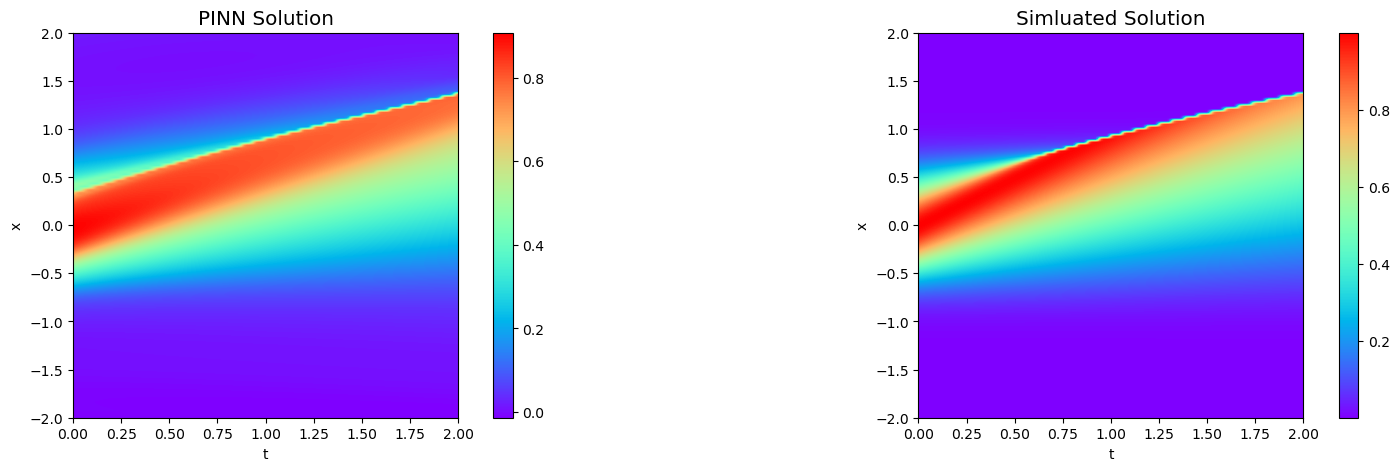

In [7]:
# plot & mse
fig = plt.figure(figsize=(20, 5))
u_viz = (u.reshape(201, 129)).T 
ext = [0 ,2, -2.0, 2.0]     # plot boundary  
ax1 = fig.add_subplot(1,2,1)
mesh =ax1.imshow(u_viz, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=.5); 
plt.colorbar(mesh) 
plt.xlabel('t'); plt.ylabel('x'); 
plt.title('PINN Solution', fontsize='x-large'); 

u_true = (batch_y.reshape(201, 129)).T 
ext = [0 ,2, -2.0, 2.0]     # plot boundary    
ax2 = fig.add_subplot(1,2,2)
mesh2 = ax2.imshow(u_true, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=.5); 
plt.colorbar(mesh2); 
plt.xlabel('t'); plt.ylabel('x'); 
plt.title('Simluated Solution', fontsize='x-large'); 

jnp.mean((u_viz - u_true)**2)

Write PINN prediction & ground truth to file

In [8]:
#np.save('nonlinear_cma_60s', (u_viz, u_true))